In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, classification_report
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [2]:
questions = pd.read_csv("./questions.csv", encoding="ISO-8859-1")
tags = pd.read_csv("./tags.csv", encoding="ISO-8859-1")

In [3]:
questions.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [4]:
tags.head()

,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [5]:
# Remove irrelevant columns 'Id', 'OwnerUserId', 'CreationDate', 'Score'
questions = questions.drop(['OwnerUserId', 'CreationDate', 'Score'], axis=1)
questions

,Id,Title,Body
0,469,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...
...,...,...,...
607277,40143190,How to execute multiline python code from a ba...,<p>I need to extend a shell script (bash). As ...
607278,40143228,How to get google reCaptcha image source using...,<p>I understood that reCaptcha loads a new fra...
607279,40143267,Updating an ManyToMany field with Django rest,<p>I'm trying to set up this API so I can use ...
607280,40143338,Most possible pairs,"<p>Given a list of values, and information on ..."


In [6]:
# Check for NaN values in questions and tags dataframes
print("Questions NaN count:", questions.isna().sum())
print("Tags NaN count:", tags.isna().sum())

# Remove rows containing NaN values in tags dataframe
tags = tags.dropna()

# Check again for NaN values in tags dataframe to confirm removal
print("Tags NaN count after dropping:", tags.isna().sum())

Questions NaN count: Id       0
Title    0
Body     0
dtype: int64
Tags NaN count: Id       0
Tag    443
dtype: int64
Tags NaN count after dropping: Id     0
Tag    0
dtype: int64


In [7]:
# Merge the two tables on the 'Id' column
merged_df = questions.merge(tags, on='Id')

# Combine all tags for each question into a list
merged_df = merged_df.groupby(['Title', 'Body', 'Id'])['Tag'].apply(list).reset_index()
merged_df['Tag'] = merged_df['Tag'].apply(lambda x: list(set(x)))

# Select a random sample of the data and print information about the resulting dataframe
merged_df = merged_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6073 entries, 0 to 6072
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   6073 non-null   object
 1   Body    6073 non-null   object
 2   Id      6073 non-null   int64 
 3   Tag     6073 non-null   object
dtypes: int64(1), object(3)
memory usage: 189.9+ KB


In [1]:
# clean text date in Title and Body column

stop_words = set(stopwords.words('english'))

def clean_text(sample): 
    """remove html tags, extra blankspace, punctuations(e.g. the hypen in 'cross-platfor' 
    and the dot before .net will not be removed, since these punctuations also appear in tags), 
    stop words and lowering cases"""
    sample = BeautifulSoup(sample, "lxml").text # remove HTML tags
    sample = re.sub(r"\s+", " ", sample) # remove extra spaces
    tokens = word_tokenize(sample)
    cleaned = {token.lower() for token in tokens
               if token not in string.punctuation and token not in stop_words}  # use set comprehension
    return " ".join(cleaned)

merged_df["Title"] = merged_df["Title"].apply(clean_text)
merged_df["Body"] = merged_df["Body"].apply(clean_text)

In [9]:
# Create a new column called 'Text', which is the concatenation of 'Title' and 'Body'
merged_df['Text'] = merged_df['Title'] + ' ' + merged_df['Body']

# Drop 'Title', 'Body', and 'Id' columns
merged_df.drop(['Title', 'Body', 'Id'], axis=1, inplace=True)
merged_df.head()

,Tag,Text
0,"[python, django, azure, django-storage, azure-...",via custom attribute url setting django azure ...
1,"[sql, django, mysql, python]",`` list values django clause require does two ...
2,"[django-views, django, django-models, python]",save/delete vs django functions view model ove...
3,"[matplotlib, python]",pixels why producing .imshow i images put exam...
4,"[sqlite, flask, python]",tests dates sqlite running using involving fla...


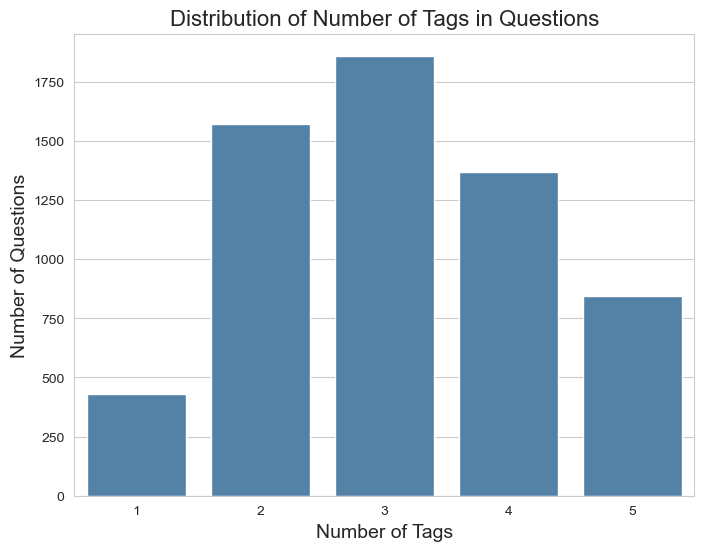

In [10]:
tags = merged_df["Tag"].tolist()
freq = [len(l) for l in tags]
count_dict = dict(Counter(freq))

sorted_counts = {k: v for k, v in sorted(count_dict.items(), key=lambda item: item[0])}

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x=list(sorted_counts.keys()), y=list(sorted_counts.values()), color='steelblue')
ax.set_title("Distribution of Number of Tags in Questions", fontsize=16)
ax.set_xlabel("Number of Tags", fontsize=14)
ax.set_ylabel("Number of Questions", fontsize=14)

plt.show()

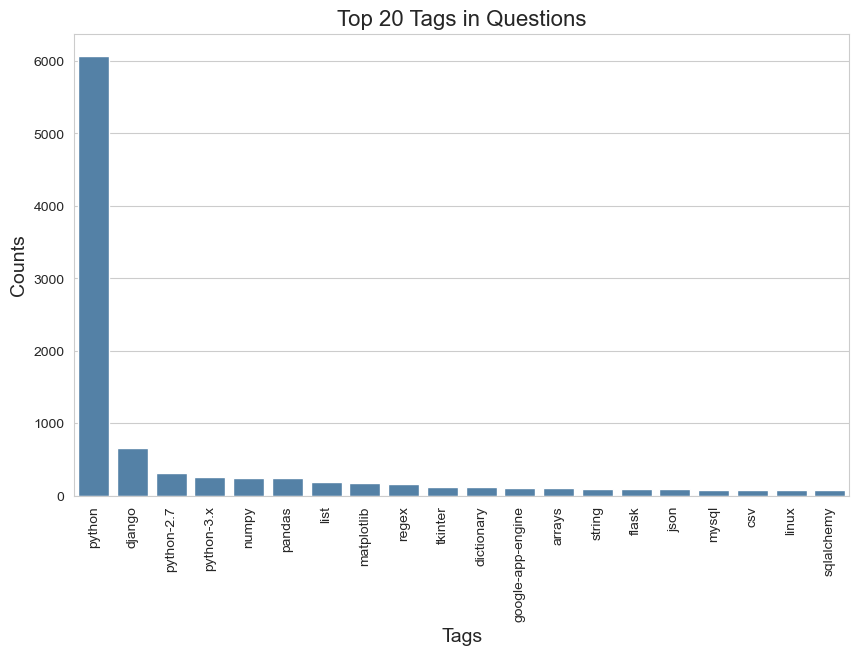

In [11]:
flatlist = sum(tags, [])
top20 = dict(Counter(flatlist).most_common(20))

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x=list(top20.keys()), y=list(top20.values()), color='steelblue')
ax.set_title("Top 20 Tags in Questions", fontsize=16)
ax.set_xlabel("Tags", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ax.set_xticklabels(list(top20.keys()), rotation=90)

plt.show()

## Training and Evaluation

In [14]:
# Split dataframe to train and test datasets

X = merged_df["Text"]
y = merged_df["Tag"]

tfidf = TfidfVectorizer(analyzer='word', max_features=10000, ngram_range=(1,3), stop_words='english')
X = tfidf.fit_transform(X)

mlb = MultiLabelBinarizer() 
y = mlb.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # , stratify=y

label_names = mlb.classes_

# Define the classifiers
classifiers = [
    OneVsRestClassifier(MultinomialNB(), n_jobs=-1),
    OneVsRestClassifier(LogisticRegression(solver='lbfgs'), n_jobs=-1),
    OneVsRestClassifier(LinearSVC(), n_jobs=-1)
]

# Train and evaluate the classifiers
results = {}
for i, clf in enumerate(classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results[f"classifier_{i+1}"] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "macro_f1": f1_score(y_test, y_pred, average='macro', zero_division=1),
        "micro_f1": f1_score(y_test, y_pred, average='micro', zero_division=1),
        "hamming_loss": hamming_loss(y_test, y_pred)
    }

In [15]:
# Print the results
for clf_name, metrics in results.items():
    print(clf_name)
    print(f"Macro F1 score: {metrics['macro_f1']:.4f}")
    print(f"Micro F1 score: {metrics['micro_f1']:.4f}")
    print(f"Hamming loss: {metrics['hamming_loss']:.4f}")

classifier_1
Macro F1 score: 0.6483
Micro F1 score: 0.6200
Hamming loss: 0.0007
classifier_2
Macro F1 score: 0.6286
Micro F1 score: 0.5382
Hamming loss: 0.0007
classifier_3
Macro F1 score: 0.6434
Micro F1 score: 0.6094
Hamming loss: 0.0007
